In [1]:
cd /mnt/users/gravityls_3/codes/Cosmotheka_tutorials/

/mnt/users/gravityls_3/codes/Cosmotheka_tutorials


In [2]:
import sys
cosmotheka_path = '/mnt/users/gravityls_3/codes/Cosmotheka'
sys.path.append(cosmotheka_path)

from cosmotheka.mappers.mapper_DESI_LRG import MapperDESILRG, MapperDESILRGZhou2023
from cosmotheka.cls.cl import Cl
from cosmotheka.cls.cov import Cov
from cosmotheka.cls.data import Data

import os

import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import healpy as hp
import numpy as np

### Configurations

In [3]:
# This only works if we have cd'ed to the Cosmotheka root directory
data = Data(data_path='./config_files/DESI_LRG/master_DESILRG.yml')

/mnt/users/gravityls_3/codes/Cosmotheka/cosmotheka/cls/data.py:439: UserWarning: A YML file was found in outdir: /mnt/extraspace/davidjamiecarlos/DESILRGs/DESILRGs_validation. Using it                  instead of input config.
  warn(


### Mappers

In [4]:
# One can instantiate the mappers directly like shown below, but we will use
# the Data class to get the mappers, to compue the C_ells 

root = '/mnt/extraspace/damonge/Datasets/DESI/lrg_xcorr_2023_v1'
root_Sailer = '/mnt/extraspace/damonge/Datasets/DESI/zenodo_LRGxPR4-DR6'
root_rand =  '/mnt/extraspace/damonge/Datasets/DESI/randoms_for_lrg_xcorr_2023_v1'
randoms_selection = root_rand + "/randoms_Rongpu.txt"
path_rerun = '/mnt/extraspace/damonge/Datasets/DESI/cosmotheka_rerun'

# Example config for MapperDESILRG
# config = {
#     "zbin": 0,  # Choose 0, 1, 2, or 3 depending on the redshift bin you want
#     "data_catalog": root + "/catalogs/dr9_lrg_pzbins.fits",
#     "weights_catalog": root + "/catalogs/more/dr9_lrg_pzbins-weights.fits",
#     "file_dndz": root + "/catalogs/more/dr9_lrg_pz.fits",
#     "stardens_path": root + "/misc/pixweight-dr7.1-0.22.0_stardens_64_ring.fits",
#     "imaging_weights_coeffs": root + "/catalogs/imaging_weights/main_lrg_linear_coeffs_pz.yaml",
#     "randoms_path": root_rand,
#     "randoms_selection": randoms_selection,  # or provide a list of randoms or a file
#     "randoms_lrgmask_path": root + "/catalogs/lrgmask_v1.1",
#     "download_missing_random": False,
#     "remove_random_after_clean": True,
#     "sample": "main",  # or "extended"
#     "nside": 2048,
#     'coords': 'C',
#     "path_rerun": path_rerun,
# }

# We have two different implementations of the MapperDESILRG class:
# In both cases, we define the overdensity density as:
# delta = (D - alpha * R) / (alpha * R)
# but in 
#  a) MapperDESILRG, alpha = <D> / <R>, where <D> is the mean density of the LRG
#  sample and <R> is the mean density of the randoms, whereas in
#  b) MapperDESILRGZhou2023, alpha = <D / R>, enforcig <delta> = 0 
# In addition, 
#  a) MapperDESILRG defines the mask = alpha * R,
#  b) MapperDESILRGZhou2023 defines a binary mask given by alpha * R. 

# mappers = {}
# mappers_Zhou23 = {}
# 
# for zbin in range(4):
#     config['zbin'] = zbin
#     mappers[zbin] = MapperDESILRG(config)
#     mappers_Zhou23[zbin] = MapperDESILRGZhou2023(config)

In [5]:
mappers = {}
mappers_Zhou23 = {}
for zbin in range(4):
   # config['zbin'] = zbin
    mappers[zbin] = data.get_mapper(f'DESI_LRG__{zbin}')
    mappers_Zhou23[zbin] = data.get_mapper(f'DESI_LRG_Zhou23__{zbin}')

Rerun read cycle for DESI_LRG_zbin0_signal_map_coordC_ns2048.fits.gz of type FITSMap


Reading /mnt/extraspace/damonge/Datasets/DESI/cosmotheka_rerun/DESI_LRG_zbin0_signal_map_coordC_ns2048.fits.gz


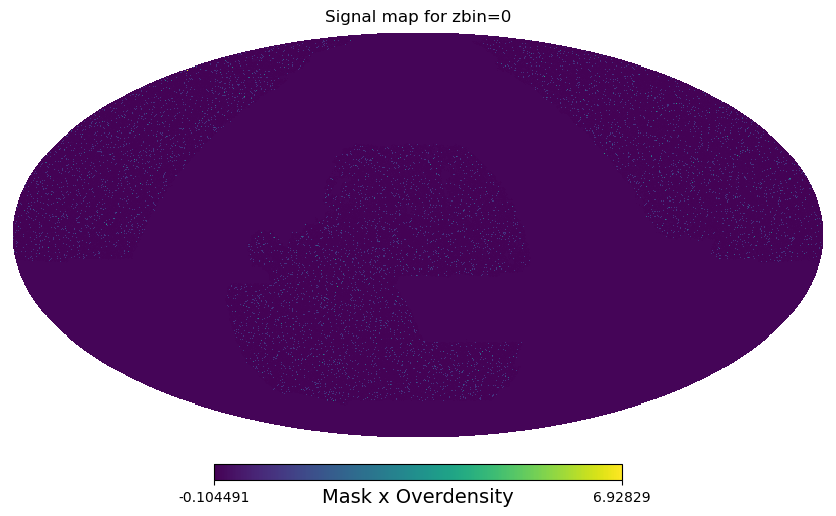

Rerun read cycle for DESI_LRG_densdefZhou2023_zbin0_signal_map_coordC_ns2048.fits.gz of type FITSMap
Reading /mnt/extraspace/damonge/Datasets/DESI/cosmotheka_rerun/DESI_LRG_densdefZhou2023_zbin0_signal_map_coordC_ns2048.fits.gz


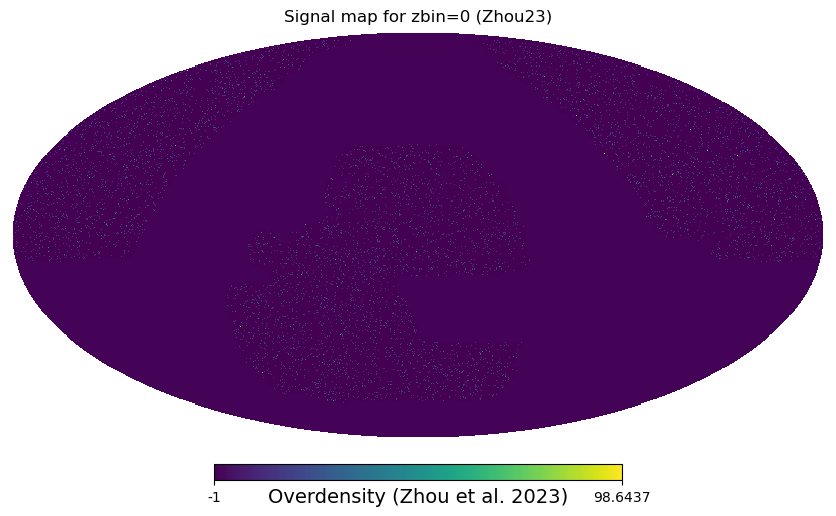

In [6]:
# We can plot the signal maps 

# The default mapper is "masked_in_input", meaning that signal = mask * delta
m = mappers[0].get_signal_map()
hp.mollview(m[0], title='Signal map for zbin=0', unit='Mask x Overdensity')
plt.show()

m = mappers_Zhou23[0].get_signal_map()
hp.mollview(m[0], title='Signal map for zbin=0 (Zhou23)', unit='Overdensity (Zhou et al. 2023)')
plt.show()

Rerun read cycle for mask_DESI_LRG_zbin0_coordC_ns2048.fits.gz of type FITSMap
Reading /mnt/extraspace/damonge/Datasets/DESI/cosmotheka_rerun/mask_DESI_LRG_zbin0_coordC_ns2048.fits.gz


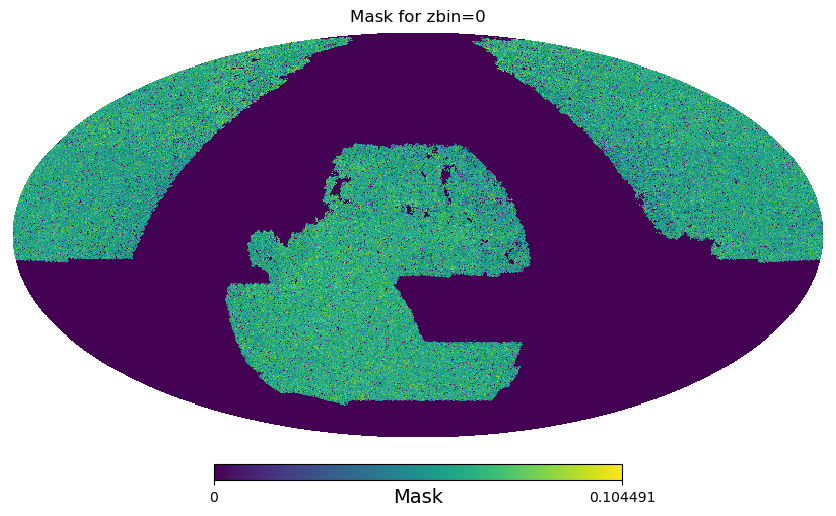

Rerun read cycle for mask_DESI_LRG_densdefZhou2023_zbin0_coordC_ns2048.fits.gz of type FITSMap
Reading /mnt/extraspace/damonge/Datasets/DESI/cosmotheka_rerun/mask_DESI_LRG_densdefZhou2023_zbin0_coordC_ns2048.fits.gz


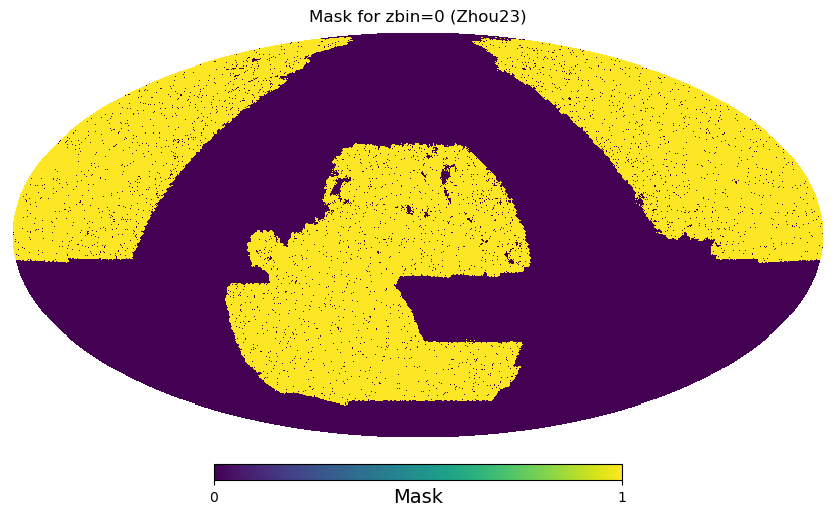

In [7]:
# We can plot the mask

# Mask = alpha * R, where alpha = <D> / <R>
m = mappers[0].get_mask()
hp.mollview(m, title='Mask for zbin=0', unit='Mask')
plt.show()

m = mappers_Zhou23[0].get_mask()
hp.mollview(m, title='Mask for zbin=0 (Zhou23)', unit='Mask')
plt.show()

### $C_\ell$'s

In [8]:
# We can compute the C_ells easily with the Cl class
cl_instances = {}
cl_Zhou23_instances = {}
for zbin in range(4):
    cl_instances[(zbin, zbin)] = Cl(data.data, f"DESI_LRG__{zbin}", f"DESI_LRG__{zbin}")
    cl_Zhou23_instances[(zbin, zbin)] = Cl(data.data, f"DESI_LRG_Zhou23__{zbin}", f"DESI_LRG_Zhou23__{zbin}")

# And their covariances. For now we compare the Cells using Sailer+24 error bars.
cov_instances = {}
cov_Zhou23_instances = {}
for zbin in range(4):
    cov_instances[(zbin, zbin)] = Cov(data.data, f"DESI_LRG__{zbin}", f"DESI_LRG__{zbin}", f"DESI_LRG__{zbin}", f"DESI_LRG__{zbin}")
    cov_Zhou23_instances[(zbin, zbin)] = Cov(data.data, f"DESI_LRG_Zhou23__{zbin}", f"DESI_LRG_Zhou23__{zbin}", f"DESI_LRG_Zhou23__{zbin}", f"DESI_LRG_Zhou23__{zbin}")

In [9]:
# Let's compare them with the official C_ells

# Read Sailer+24 Cells
import json
import os
fname = os.path.join(root_Sailer, 'data/lrg_cross_pr4+dr6.json')
cls_Sailer = json.load(open(fname, "r"))
print(cls_Sailer.keys())
print(cls_Sailer['ledges'])
print(cls_Sailer['ell'])

# From the Sailer+24 paper, 
shot_Sailer = np.array([4.07, 2.25, 2.05, 2.25]) * 1e-6  # Shot noise from Sailer+2024 Table 1

dict_keys(['README', 'nside', 'map names', 'ledges', 'ell', 'pixwin', 'cl_DR6_LRGz1', 'wl_DR6_LRGz1', 'cl_PR4_LRGz1', 'wl_PR4_LRGz1', 'cl_DR6_LRGz2', 'wl_DR6_LRGz2', 'cl_PR4_LRGz2', 'wl_PR4_LRGz2', 'cl_DR6_LRGz3', 'wl_DR6_LRGz3', 'cl_PR4_LRGz3', 'wl_PR4_LRGz3', 'cl_DR6_LRGz4', 'wl_DR6_LRGz4', 'cl_PR4_LRGz4', 'wl_PR4_LRGz4', 'cl_LRGz1_LRGz1', 'wl_LRGz1_LRGz1', 'cl_LRGz2_LRGz2', 'wl_LRGz2_LRGz2', 'cl_LRGz3_LRGz3', 'wl_LRGz3_LRGz3', 'cl_LRGz4_LRGz4', 'wl_LRGz4_LRGz4', 'cov_DR6_LRGz1_DR6_LRGz1', 'cov_DR6_LRGz1_DR6_LRGz2', 'cov_DR6_LRGz1_DR6_LRGz3', 'cov_DR6_LRGz1_DR6_LRGz4', 'cov_DR6_LRGz2_DR6_LRGz1', 'cov_DR6_LRGz2_DR6_LRGz2', 'cov_DR6_LRGz2_DR6_LRGz3', 'cov_DR6_LRGz2_DR6_LRGz4', 'cov_DR6_LRGz3_DR6_LRGz1', 'cov_DR6_LRGz3_DR6_LRGz2', 'cov_DR6_LRGz3_DR6_LRGz3', 'cov_DR6_LRGz3_DR6_LRGz4', 'cov_DR6_LRGz4_DR6_LRGz1', 'cov_DR6_LRGz4_DR6_LRGz2', 'cov_DR6_LRGz4_DR6_LRGz3', 'cov_DR6_LRGz4_DR6_LRGz4', 'cov_DR6_LRGz1_PR4_LRGz1', 'cov_DR6_LRGz1_PR4_LRGz2', 'cov_DR6_LRGz1_PR4_LRGz3', 'cov_DR6_LRGz1_PR

In [10]:
# Check that the binning is the same as Sailer+24.
# Note: there is a small difference but for the porposes of comparing both
# Cells, it should be negligible.
ell, cl = cl_instances[(0, 0)].get_ell_cl()
print(ell)

[   9.5   32.    62.   102.   151.5  211.   280.5  359.5  448.5  548.
  657.   775.5  904.5 1034.5 1172.  1331.  1511.5 1716.5 1949.  2213.
 2513.  2853.5 3240.  3679.5 4178.5 4745.  5388.5 5937. ]


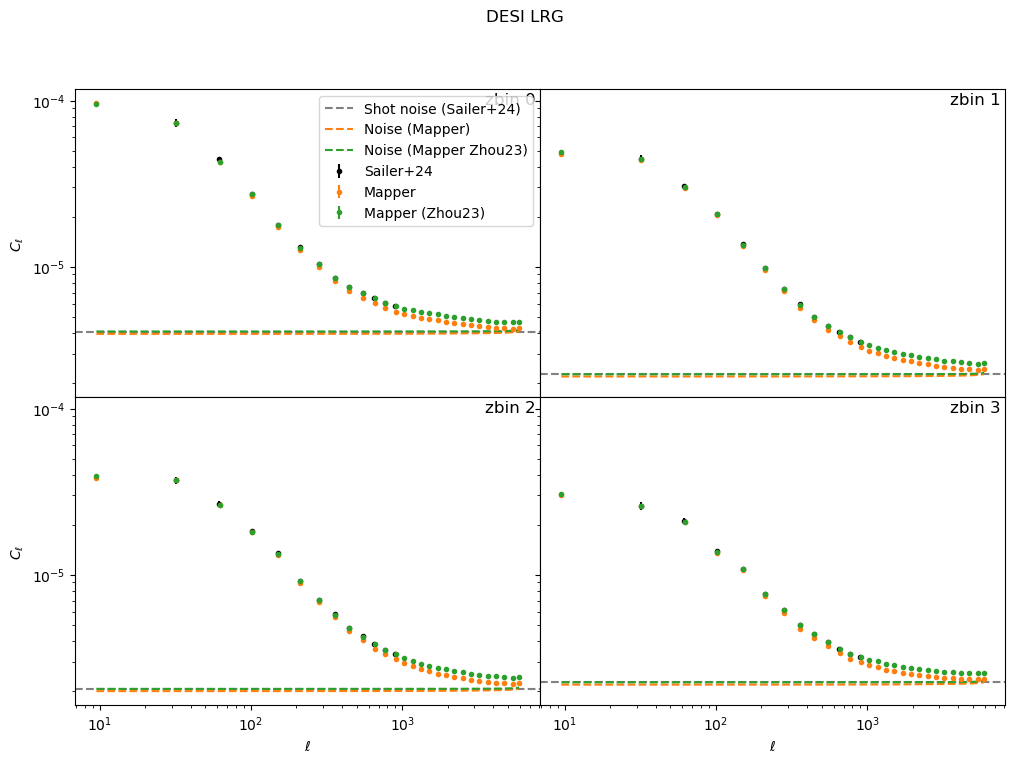

In [11]:
f, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0.0})
ax = ax.flatten()

for zbin in range(4):
    ell, cl = cl_instances[(zbin, zbin)].get_ell_cl()
    _, nl = cl_instances[(zbin, zbin)].get_ell_nl()
    # err = np.sqrt(np.diag(cov_instances[(zbin, zbin)].get_covariance()))
    err = np.zeros_like(cl[0])

    ell, cl_Zhou23 = cl_Zhou23_instances[(zbin, zbin)].get_ell_cl()
    _, nl_Zhou23 = cl_Zhou23_instances[(zbin, zbin)].get_ell_nl()
    # err_Zhou23 = np.sqrt(np.diag(cov_Zhou23_instances[(zbin, zbin)].get_covariance()))
    err_Zhou23 = np.zeros_like(cl[0])

    # Sailer's
    pzbin = zbin + 1
    ell_Sailer = np.array(cls_Sailer['ell'])
    cl_Sailer = np.array(cls_Sailer[f'cl_LRGz{pzbin}_LRGz{pzbin}'])
    err_Sailer = np.sqrt(np.diag(cls_Sailer[f'cov_LRGz{pzbin}_LRGz{pzbin}_LRGz{pzbin}_LRGz{pzbin}']))
    shot = shot_Sailer[zbin]

    ax[zbin].errorbar(ell_Sailer, cl_Sailer, yerr=err_Sailer, label=f'Sailer+24',
                  fmt='.', color='black')
    ax[zbin].errorbar(ell, cl[0] + nl[0], yerr=err, label=f'Mapper', color='C1', fmt='.')
    ax[zbin].errorbar(ell, cl_Zhou23[0] + nl_Zhou23[0], yerr=err_Zhou23, label=f'Mapper (Zhou23)', color='C2', fmt='.')

    # Noise
    ax[zbin].axhline(shot, color='gray', linestyle='--', label=f'Shot noise (Sailer+24)')
    ax[zbin].plot(ell, nl[0], color='C1', linestyle='--', label=f'Noise (Mapper)')
    ax[zbin].plot(ell, nl_Zhou23[0], color='C2', linestyle='--', label=f'Noise (Mapper Zhou23)')

    # Add text with the redshift bin
    ax[zbin].text(0.99, 0.99, f'zbin {zbin}', transform=ax[zbin].transAxes,
                  fontsize=12, verticalalignment='top', horizontalalignment='right')


ax[0].legend()

ax[0].set_ylabel(r'$C_\ell$')
ax[2].set_ylabel(r'$C_\ell$')

ax[2].set_xlabel(r'$\ell$')
ax[3].set_xlabel(r'$\ell$')

ax[0].set_yscale("log")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[3].set_xscale("log")

f.suptitle(f'DESI LRG')
plt.show()
plt.close()



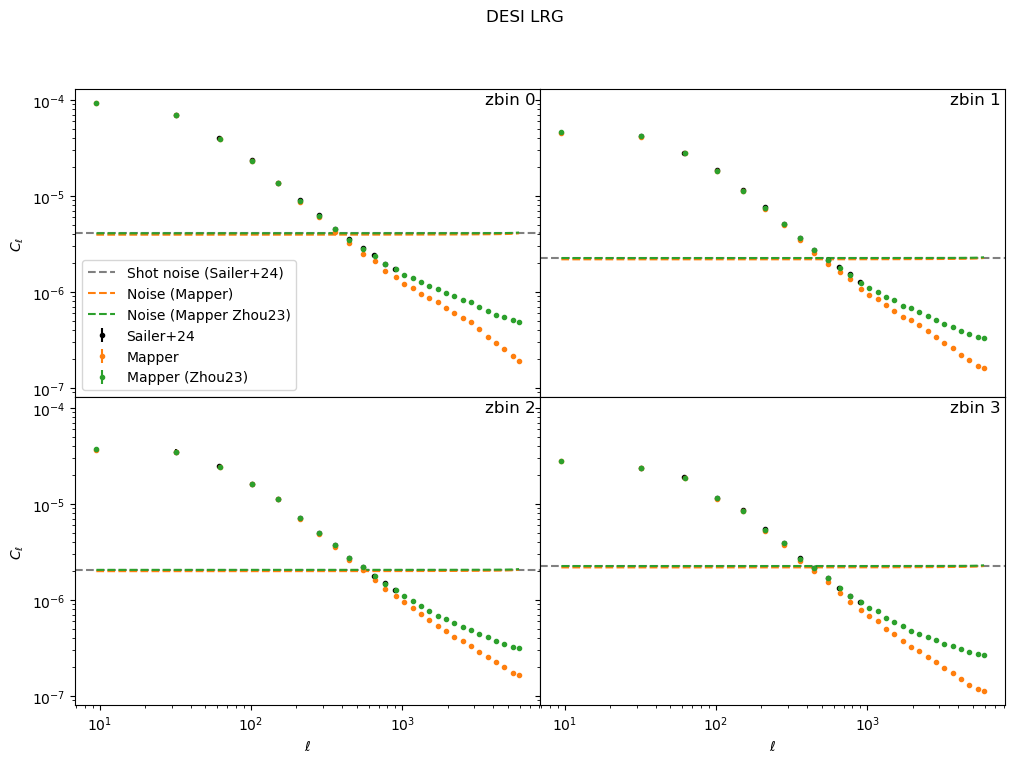

In [12]:
f, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0.0})
ax = ax.flatten()

for zbin in range(4):
    ell, cl = cl_instances[(zbin, zbin)].get_ell_cl()
    _, nl = cl_instances[(zbin, zbin)].get_ell_nl()
    # err = np.sqrt(np.diag(cov_instances[(zbin, zbin)].get_covariance()))
    err = np.zeros_like(cl[0])

    ell, cl_Zhou23 = cl_Zhou23_instances[(zbin, zbin)].get_ell_cl()
    _, nl_Zhou23 = cl_Zhou23_instances[(zbin, zbin)].get_ell_nl()
    # err_Zhou23 = np.sqrt(np.diag(cov_Zhou23_instances[(zbin, zbin)].get_covariance()))
    err_Zhou23 = np.zeros_like(cl[0])

    # Sailer's
    pzbin = zbin + 1
    ell_Sailer = np.array(cls_Sailer['ell'])
    cl_Sailer = np.array(cls_Sailer[f'cl_LRGz{pzbin}_LRGz{pzbin}'])
    err_Sailer = np.sqrt(np.diag(cls_Sailer[f'cov_LRGz{pzbin}_LRGz{pzbin}_LRGz{pzbin}_LRGz{pzbin}']))
    shot = shot_Sailer[zbin]

    ax[zbin].errorbar(ell_Sailer, cl_Sailer - shot, yerr=err_Sailer, label=f'Sailer+24',
                  fmt='.', color='black')
    ax[zbin].errorbar(ell, cl[0], yerr=err, label=f'Mapper', color='C1', fmt='.')
    ax[zbin].errorbar(ell, cl_Zhou23[0], yerr=err_Zhou23, label=f'Mapper (Zhou23)', color='C2', fmt='.')

    # Noise
    ax[zbin].axhline(shot, color='gray', linestyle='--', label=f'Shot noise (Sailer+24)')
    ax[zbin].plot(ell, nl[0], color='C1', linestyle='--', label=f'Noise (Mapper)')
    ax[zbin].plot(ell, nl_Zhou23[0], color='C2', linestyle='--', label=f'Noise (Mapper Zhou23)')

    # Add text with the redshift bin
    ax[zbin].text(0.99, 0.99, f'zbin {zbin}', transform=ax[zbin].transAxes,
                  fontsize=12, verticalalignment='top', horizontalalignment='right')


ax[0].legend()

ax[0].set_ylabel(r'$C_\ell$')
ax[2].set_ylabel(r'$C_\ell$')

ax[2].set_xlabel(r'$\ell$')
ax[3].set_xlabel(r'$\ell$')

ax[0].set_yscale("log")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[3].set_xscale("log")

f.suptitle(f'DESI LRG')
plt.show()
plt.close()



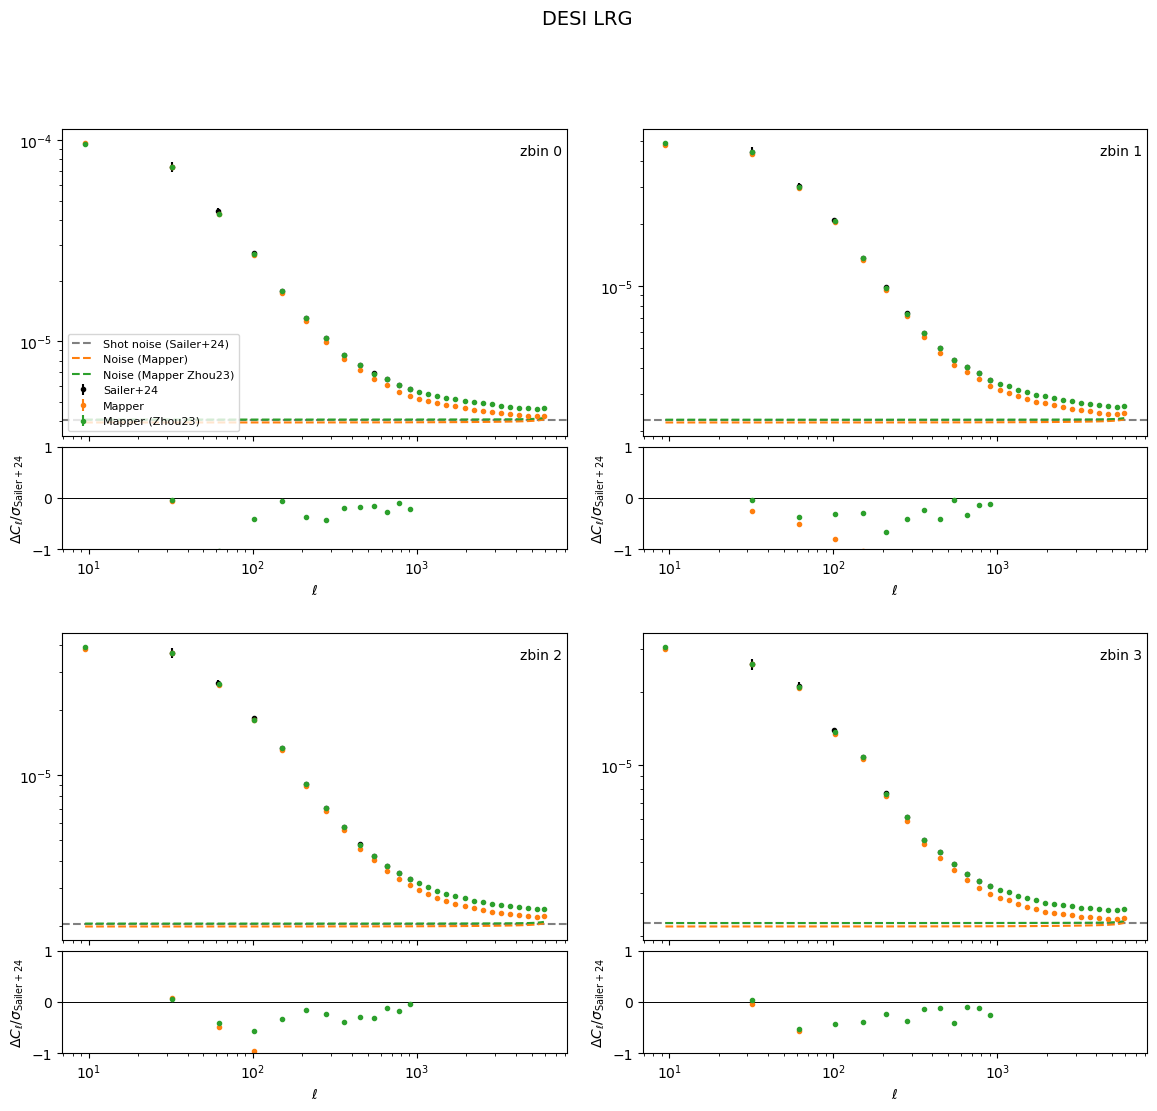

In [13]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 12))
outer_gs = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.2)

for zbin in range(4):
    # which outer cell
    row = zbin // 2
    col = zbin % 2
    outer_idx = row * 2 + col
    outer = outer_gs[outer_idx]

    # split each outer cell into two rows: top=C_ell, bottom=reldev
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer,
                                                height_ratios=[3, 1],
                                                hspace=0.05)

    ax_top = fig.add_subplot(inner_gs[0])
    ax_bot = fig.add_subplot(inner_gs[1], sharex=ax_top)

    # --- retrieve data (unchanged) ---
    ell, cl = cl_instances[(zbin, zbin)].get_ell_cl()
    _, nl = cl_instances[(zbin, zbin)].get_ell_nl()

    ell, cl_Zhou23 = cl_Zhou23_instances[(zbin, zbin)].get_ell_cl()
    _, nl_Zhou23 = cl_Zhou23_instances[(zbin, zbin)].get_ell_nl()

    # Sailer
    pzbin = zbin + 1
    ell_Sailer = np.array(cls_Sailer['ell'])
    cl_Sailer = np.array(cls_Sailer[f'cl_LRGz{pzbin}_LRGz{pzbin}'])
    err_Sailer = np.sqrt(np.diag(cls_Sailer[f'cov_LRGz{pzbin}_LRGz{pzbin}_LRGz{pzbin}_LRGz{pzbin}']))
    shot = shot_Sailer[zbin]


    # Relative dev. (compare only where Sailer has coverage)
    sel = (ell >= ell_Sailer[0]-1) & (ell <= ell_Sailer[-1]+1)
    ref = cl_Sailer
    reldev = (cl[0, sel] + nl[0, sel] - ref) / err_Sailer
    reldev_Zhou23 = (cl_Zhou23[0, sel] + nl_Zhou23[0, sel] - ref) / err_Sailer

    # -------------------------
    # Top: C_ell (with errors and noise)
    # -------------------------
    ax_top.errorbar(ell_Sailer, cl_Sailer, yerr=err_Sailer,
                    fmt='.', color='k', label='Sailer+24')
    ax_top.errorbar(ell, cl[0] + nl[0], yerr=err, fmt='.', color='C1', label='Mapper')
    ax_top.errorbar(ell, cl_Zhou23[0] + nl_Zhou23[0], yerr=err_Zhou23, fmt='.', color='C2', label='Mapper (Zhou23)')

    # noise lines
    ax_top.axhline(shot, color='gray', linestyle='--', label='Shot noise (Sailer+24)')
    ax_top.plot(ell, nl[0], color='C1', linestyle='--', label='Noise (Mapper)')
    ax_top.plot(ell, nl_Zhou23[0], color='C2', linestyle='--', label='Noise (Mapper Zhou23)')

    ax_top.set_yscale('log')
    ax_top.set_xscale('log')
    # hide x tick labels on top subplot
    plt.setp(ax_top.get_xticklabels(), visible=False)

    # text
    ax_top.text(0.99, 0.95, f'zbin {zbin}', transform=ax_top.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right')

    # show legend only in the first top panel
    if zbin == 0:
        ax_top.legend(fontsize=8, loc='lower left')

    # -------------------------
    # Bottom: relative deviation wrt Sailer
    # -------------------------
    # plot reldev on ell[sel] with propagated error ~ err[sel]/ref_on_sel
    ax_bot.errorbar(ell[sel], reldev, fmt='.', color='C1', label='Mapper reldev')
    ax_bot.errorbar(ell[sel], reldev_Zhou23, fmt='.', color='C2',
                    label='Mapper(Zhou23) reldev')
    ax_bot.axhline(0.0, color='k', linewidth=0.7)
    ax_bot.set_xscale('log')
    ax_bot.set_ylabel(r'$\Delta C_\ell / \sigma_{\rm Sailer+24}$')
    ax_bot.set_xlabel(r'$\ell$')

    # tighten y-limits for bottom to focus on deviations
    # (adjust as wanted)
    ax_bot.set_ylim(-1., 1.)

# overall title
fig.suptitle('DESI LRG', fontsize=14)

plt.show()
plt.close()

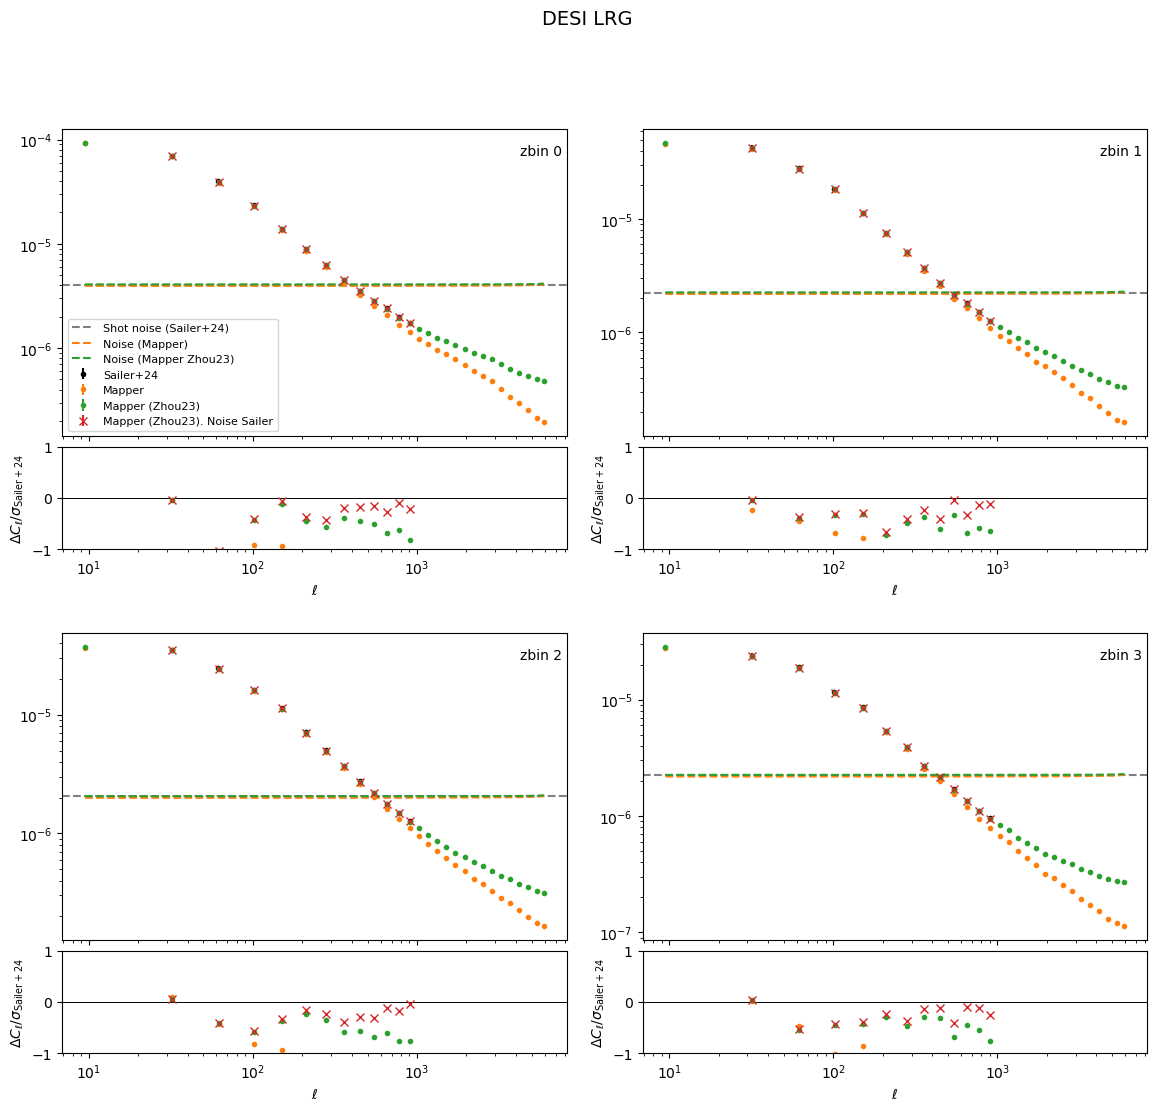

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 12))
outer_gs = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.2)

for zbin in range(4):
    # which outer cell
    row = zbin // 2
    col = zbin % 2
    outer_idx = row * 2 + col
    outer = outer_gs[outer_idx]

    # split each outer cell into two rows: top=C_ell, bottom=reldev
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer,
                                                height_ratios=[3, 1],
                                                hspace=0.05)

    ax_top = fig.add_subplot(inner_gs[0])
    ax_bot = fig.add_subplot(inner_gs[1], sharex=ax_top)

    # --- retrieve data (unchanged) ---
    ell, cl = cl_instances[(zbin, zbin)].get_ell_cl()
    _, nl = cl_instances[(zbin, zbin)].get_ell_nl()

    ell, cl_Zhou23 = cl_Zhou23_instances[(zbin, zbin)].get_ell_cl()
    _, nl_Zhou23 = cl_Zhou23_instances[(zbin, zbin)].get_ell_nl()

    # Sailer
    pzbin = zbin + 1
    ell_Sailer = np.array(cls_Sailer['ell'])
    cl_Sailer = np.array(cls_Sailer[f'cl_LRGz{pzbin}_LRGz{pzbin}'])
    err_Sailer = np.sqrt(np.diag(cls_Sailer[f'cov_LRGz{pzbin}_LRGz{pzbin}_LRGz{pzbin}_LRGz{pzbin}']))
    shot = shot_Sailer[zbin]


    # Relative dev. (compare only where Sailer has coverage)
    sel = (ell >= ell_Sailer[0]-1) & (ell <= ell_Sailer[-1]+1)
    ref = cl_Sailer - shot
    reldev = (cl[0, sel] - ref) / err_Sailer
    reldev_Zhou23 = (cl_Zhou23[0, sel] - ref) / err_Sailer

    # Correct noise for Zhou23
    cl_Zhou23_nlSailer = cl_Zhou23[0, sel] + nl_Zhou23[0, sel] - shot
    reldev_Zhou23_nlSailer = (cl_Zhou23_nlSailer - ref) / err_Sailer

    # -------------------------
    # Top: C_ell (with errors and noise)
    # -------------------------
    ax_top.errorbar(ell_Sailer, cl_Sailer - shot, yerr=err_Sailer,
                    fmt='.', color='k', label='Sailer+24')
    ax_top.errorbar(ell, cl[0], yerr=err, fmt='.', color='C1', label='Mapper')
    ax_top.errorbar(ell, cl_Zhou23[0], yerr=err_Zhou23, fmt='.', color='C2', label='Mapper (Zhou23)')
    ax_top.errorbar(ell[sel], cl_Zhou23_nlSailer, yerr=err_Zhou23[sel], fmt='x', color='C3', label='Mapper (Zhou23). Noise Sailer')

    # noise lines
    ax_top.axhline(shot, color='gray', linestyle='--', label='Shot noise (Sailer+24)')
    ax_top.plot(ell, nl[0], color='C1', linestyle='--', label='Noise (Mapper)')
    ax_top.plot(ell, nl_Zhou23[0], color='C2', linestyle='--', label='Noise (Mapper Zhou23)')

    ax_top.set_yscale('log')
    ax_top.set_xscale('log')
    # hide x tick labels on top subplot
    plt.setp(ax_top.get_xticklabels(), visible=False)

    # text
    ax_top.text(0.99, 0.95, f'zbin {zbin}', transform=ax_top.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right')

    # show legend only in the first top panel
    if zbin == 0:
        ax_top.legend(fontsize=8, loc='lower left')

    # -------------------------
    # Bottom: relative deviation wrt Sailer
    # -------------------------
    # plot reldev on ell[sel] with propagated error ~ err[sel]/ref_on_sel
    ax_bot.errorbar(ell[sel], reldev, fmt='.', color='C1', label='Mapper reldev')
    ax_bot.errorbar(ell[sel], reldev_Zhou23, fmt='.', color='C2',
                    label='Mapper(Zhou23) reldev')
    ax_bot.errorbar(ell[sel], reldev_Zhou23_nlSailer, fmt='x', color='C3',
                    label='Mapper(Zhou23). Noise Sailer reldev')
    ax_bot.axhline(0.0, color='k', linewidth=0.7)
    ax_bot.set_xscale('log')
    ax_bot.set_ylabel(r'$\Delta C_\ell / \sigma_{\rm Sailer+24}$')
    ax_bot.set_xlabel(r'$\ell$')

    # tighten y-limits for bottom to focus on deviations
    # (adjust as wanted)
    ax_bot.set_ylim(-1., 1.)

# overall title
fig.suptitle('DESI LRG', fontsize=14)

plt.show()
plt.close()